# Time Series Forecasting Results Visualization

Interactive analysis of AutoGluon, LSTM, and XGBoost forecasting models.

## Overview

This notebook visualizes:
- Model performance comparison across 5 metrics
- AutoGluon's internal model leaderboard
- 24-hour future forecasts for all sensors
- LSTM training convergence



## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10


# Create output directory for images
Path("output_images").mkdir(exist_ok=True)
print("✓ Setup complete")

✓ Setup complete


## Load Data

In [3]:
# Load metrics
combined_metrics_raw = pd.read_csv('comparison_results/combined_metrics.csv', index_col=0)
comparison_report = pd.read_csv('comparison_results/comparison_report.csv')
autogluon_leaderboard = pd.read_csv('comparison_results/autogluon_leaderboard.csv')

# Transform combined_metrics to long format
combined_metrics = combined_metrics_raw.reset_index().melt(
    id_vars='index', var_name='Metric', value_name='Value'
).rename(columns={'index': 'Model'})

# Load predictions
autogluon_preds = pd.read_parquet('comparison_results/autogluon_predictions.parquet')
lstm_preds = pd.read_parquet('comparison_results/lstm_predictions.parquet')
xgboost_preds = pd.read_parquet('comparison_results/xgboost_predictions.parquet')
test_actuals = pd.read_parquet('comparison_results/test_actuals.parquet')

# Load training history
lstm_history = pd.read_csv('comparison_results/lstm_training_history.csv')

# Standardize prediction columns
autogluon_preds['prediction'] = autogluon_preds['mean']
lstm_preds['prediction'] = lstm_preds['mean']
xgboost_preds['prediction'] = xgboost_preds['predicted']

print("✓ Data loaded successfully")
print(f"\nDataset Info:")
print(f"  Forecast points: {len(autogluon_preds)}")
print(f"  Test actuals: {len(test_actuals):,}")
print(f"  Sensors: {test_actuals['item_id'].nunique()}")

✓ Data loaded successfully

Dataset Info:
  Forecast points: 216
  Test actuals: 704,967
  Sensors: 9


---

## 1. Model Performance Comparison

Compare all three models across 5 key metrics.

**Metrics (lower is better):**
- **MAE**: Mean Absolute Error
- **RMSE**: Root Mean Squared Error  
- **MAPE**: Mean Absolute Percentage Error
- **MASE**: Mean Absolute Scaled Error
- **SMAPE**: Symmetric Mean Absolute Percentage Error

In [4]:
# Display comparison table
print("Model Performance Summary")
print("=" * 80)
display(comparison_report)

# Determine overall winner
winners = comparison_report['Winner'].value_counts()
print(f"\n🏆 Overall Winner: {winners.idxmax()} (won {winners.max()}/5 metrics)")

Model Performance Summary


,Metric,AutoGluon,LSTM,XGBoost,Winner
0,MAE,0.394749,1.762602,0.499055,AutoGluon
1,RMSE,1.277966,1.982114,1.916459,AutoGluon
2,MAPE,0.004039,0.049098,0.012674,AutoGluon
3,MASE,0.628256,56.463756,14.758254,AutoGluon
4,SMAPE,0.225770,26.282419,23.068799,AutoGluon



🏆 Overall Winner: AutoGluon (won 5/5 metrics)


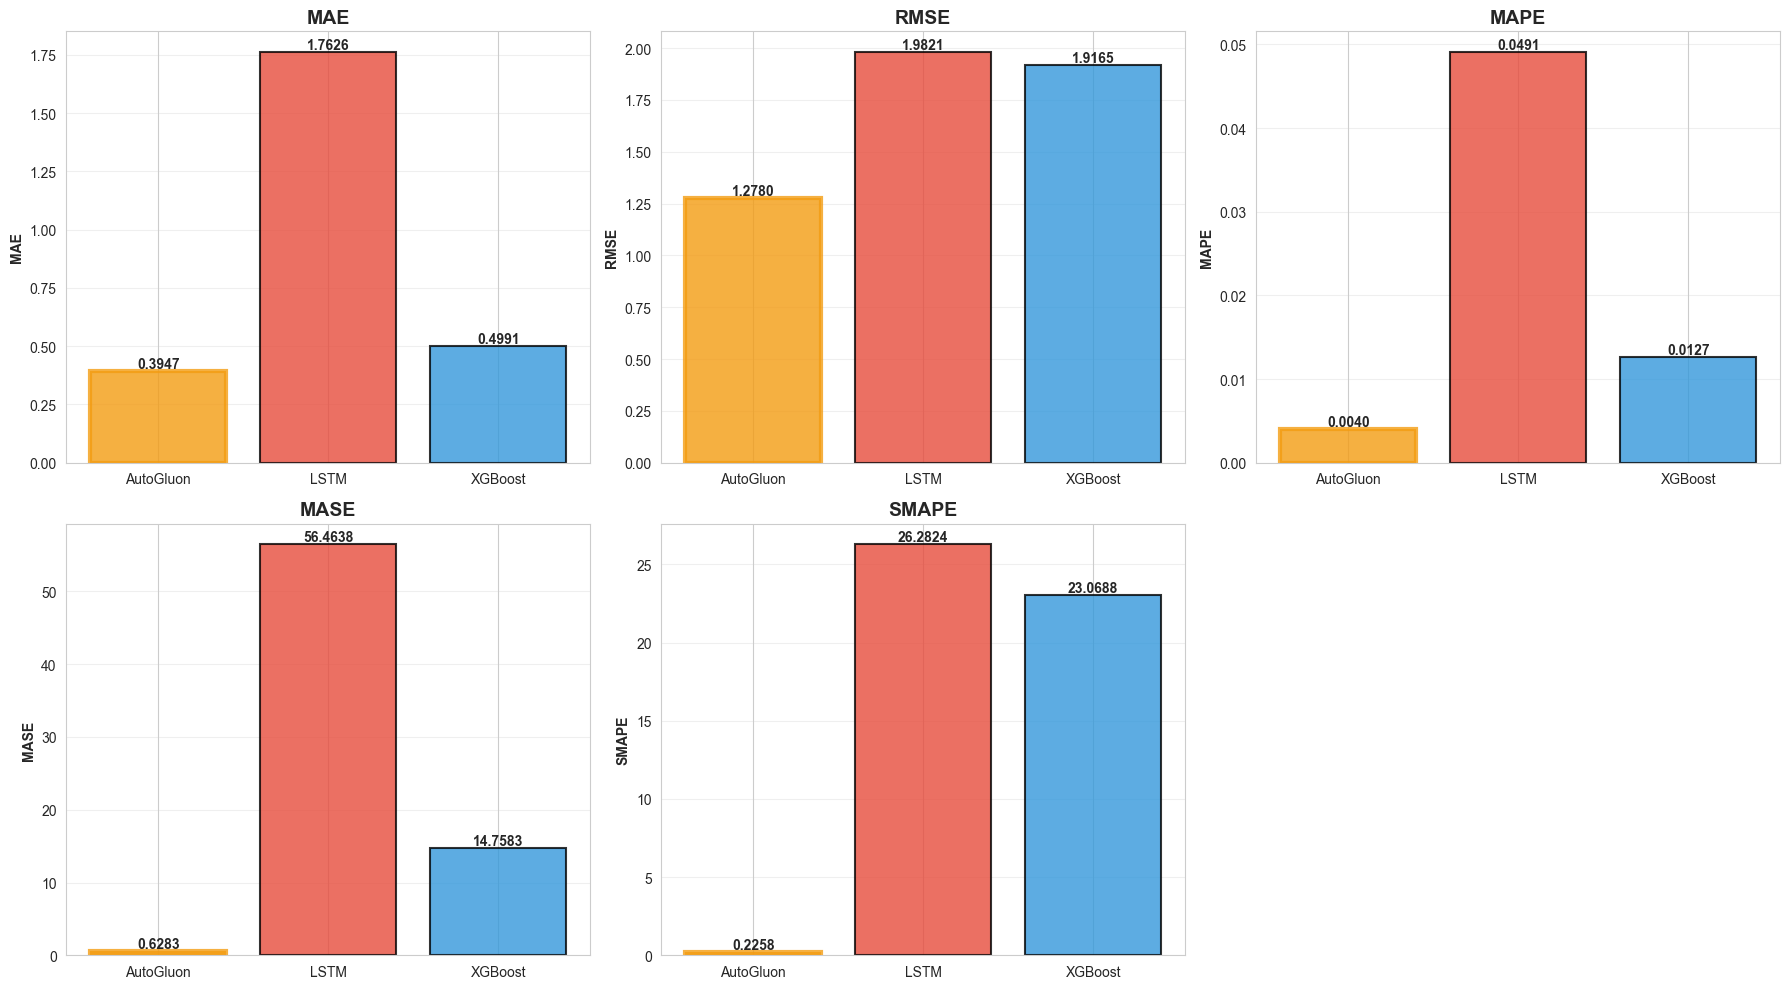

In [6]:
# Visualize metric comparison
metrics = ['MAE', 'RMSE', 'MAPE', 'MASE', 'SMAPE']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    metric_data = combined_metrics[combined_metrics['Metric'] == metric]
    models = metric_data['Model'].values
    values = metric_data['Value'].values
    
    colors = ['#2ecc71', '#e74c3c', '#3498db']
    bars = ax.bar(models, values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Highlight best
    best_idx = np.argmin(values)
    bars[best_idx].set_color('#f39c12')
    bars[best_idx].set_linewidth(3)
    
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

fig.delaxes(axes[5])
plt.tight_layout()
plt.savefig('output_images/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 2. AutoGluon Model Leaderboard

AutoGluon trains multiple models internally and creates an ensemble. Let's see which models performed best.

In [7]:
print("AutoGluon Top 10 Models")
print("=" * 80)
display(autogluon_leaderboard.head(10)[['model', 'score_val', 'fit_time_marginal', 'pred_time_val']])

AutoGluon Top 10 Models


,model,score_val,fit_time_marginal,pred_time_val
0,WeightedEnsemble,-0.099652,0.142154,1.173464
1,Chronos[bolt_small],-0.099652,4.838930,1.173464
2,Naive,-0.103641,0.009001,2.737638
3,TemporalFusionTransformer,-0.193840,138.249424,0.024834
4,DirectTabular,-0.222272,0.550472,0.044000
5,SeasonalNaive,-0.224428,0.007997,1.568388
6,ETS,-0.251420,0.009001,1.428270
7,RecursiveTabular,-0.292456,0.569332,0.074502
8,Theta,-0.307456,0.006998,0.836309


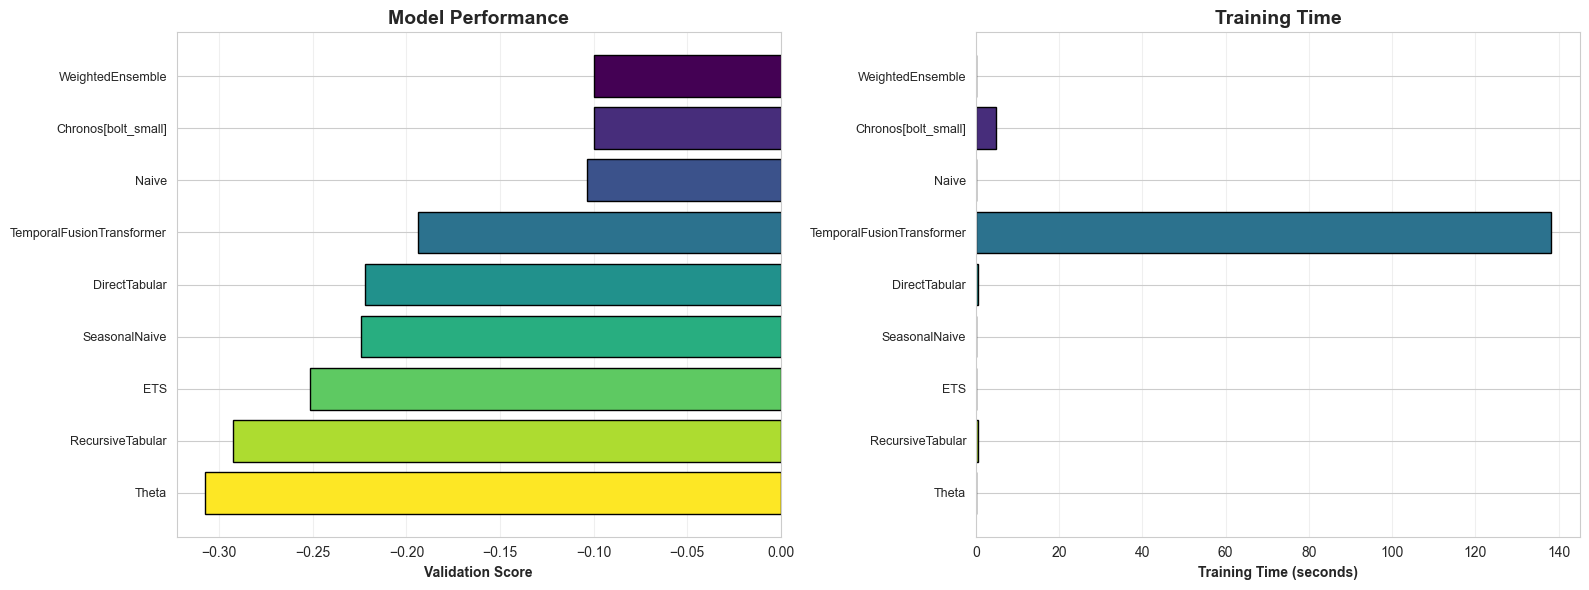


Best model: WeightedEnsemble
Score: -0.0997


In [8]:
top_models = autogluon_leaderboard.head(10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(top_models)))

# Validation scores
ax1.barh(range(len(top_models)), top_models['score_val'], color=colors, edgecolor='black')
ax1.set_yticks(range(len(top_models)))
ax1.set_yticklabels(top_models['model'], fontsize=9)
ax1.set_xlabel('Validation Score', fontweight='bold')
ax1.set_title('Model Performance', fontweight='bold', fontsize=14)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Training time
ax2.barh(range(len(top_models)), top_models['fit_time_marginal'], color=colors, edgecolor='black')
ax2.set_yticks(range(len(top_models)))
ax2.set_yticklabels(top_models['model'], fontsize=9)
ax2.set_xlabel('Training Time (seconds)', fontweight='bold')
ax2.set_title('Training Time', fontweight='bold', fontsize=14)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('output_images/autogluon_leaderboard.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest model: {top_models.iloc[0]['model']}")
print(f"Score: {top_models.iloc[0]['score_val']:.4f}")

---

## 3. Future Forecasts

Visualize 24-hour ahead forecasts for each sensor.

**Note:** These are predictions beyond the test period (future forecasts starting Jan 30, 2024).

In [9]:
sensors = autogluon_preds['item_id'].unique()
print(f"Available sensors ({len(sensors)}):")
for i, sensor in enumerate(sensors, 1):
    print(f"  {i}. {sensor}")

Available sensors (9):
  1. 0:HC5Y013CP.SOTTN
  2. 4:HTSN1C4T0.CPY5O
  3. 5.CF:1H45CP0OYSNT
  4. 5H4C:S.YPLOTC1N00
  5. :PCT01SN0LH.5Y3CO
  6. C.OH0TU:C1Y4HON35
  7. HO.T:C4F5C0O5U1YN
  8. S:CF5PO.5H03Y1NTC
  9. T:4FU4PRBV3NO0V_0PLM40R-.34


Visualizing 24-hour forecast for: 0:HC5Y013CP.SOTTN


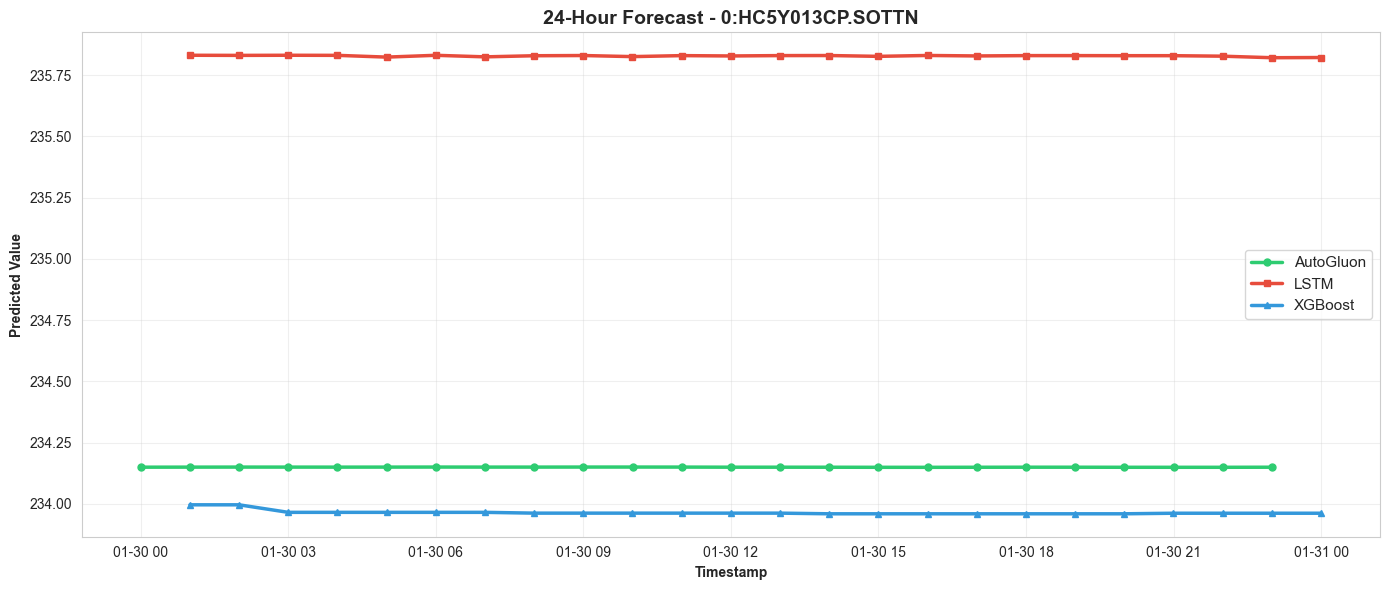

In [10]:
# Select sensor to visualize
sensor_id = sensors[0]  # Change index to view different sensor

print(f"Visualizing 24-hour forecast for: {sensor_id}")

# Filter data for selected sensor
ag = autogluon_preds[autogluon_preds['item_id'] == sensor_id].sort_values('timestamp')
lstm = lstm_preds[lstm_preds['item_id'] == sensor_id].sort_values('timestamp')
xgb = xgboost_preds[xgboost_preds['item_id'] == sensor_id].sort_values('timestamp')

# Create visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(ag['timestamp'], ag['prediction'], 
        label='AutoGluon', color='#2ecc71', linewidth=2.5, marker='o', markersize=5)
ax.plot(lstm['timestamp'], lstm['prediction'], 
        label='LSTM', color='#e74c3c', linewidth=2.5, marker='s', markersize=5)
ax.plot(xgb['timestamp'], xgb['prediction'], 
        label='XGBoost', color='#3498db', linewidth=2.5, marker='^', markersize=5)

ax.set_title(f'24-Hour Forecast - {sensor_id}', fontweight='bold', fontsize=14)
ax.set_xlabel('Timestamp', fontweight='bold')
ax.set_ylabel('Predicted Value', fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'output_images/forecast_sensor.png', dpi=300, bbox_inches='tight')
plt.show()

### Batch Generate All Sensors

Generating forecast plots for 9 sensors...



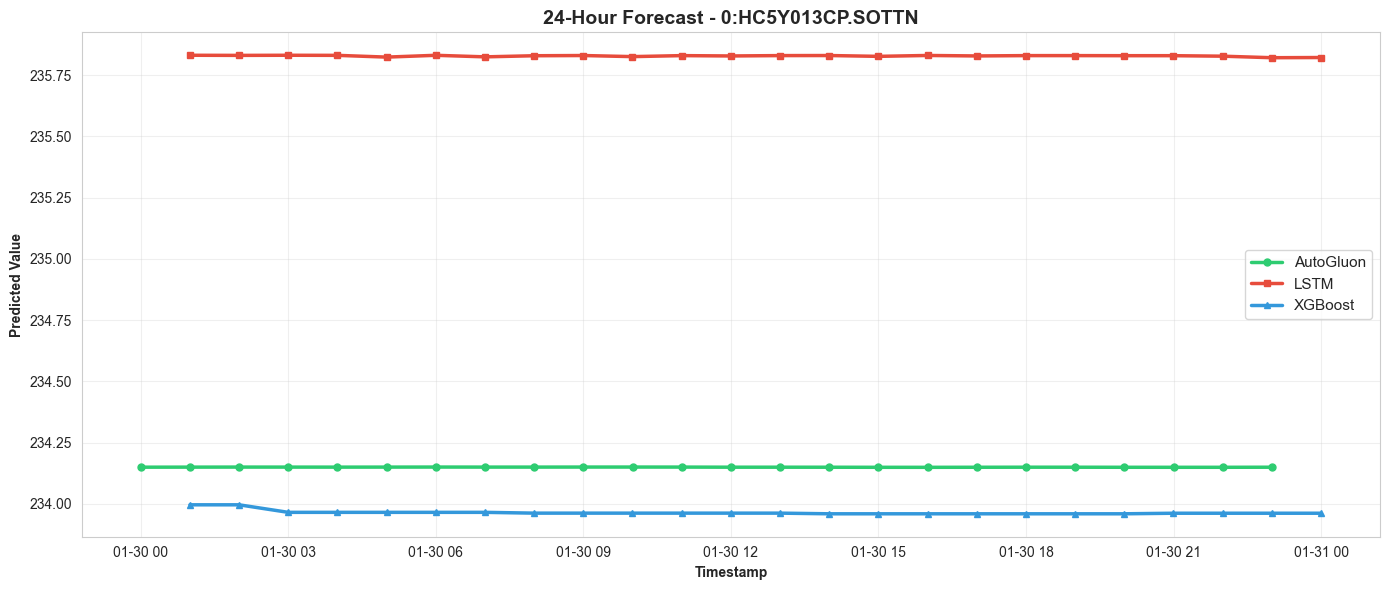

✓ Generated: forecast_0_HC5Y013CP_SOTTN.png


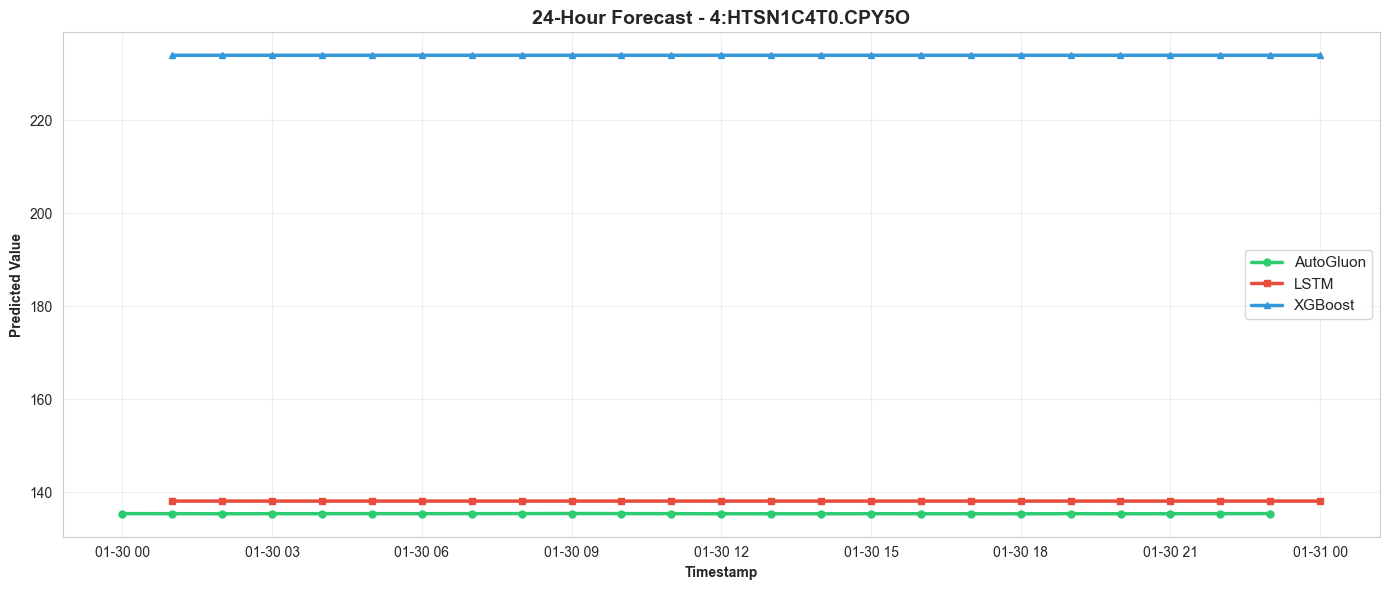

✓ Generated: forecast_4_HTSN1C4T0_CPY5O.png


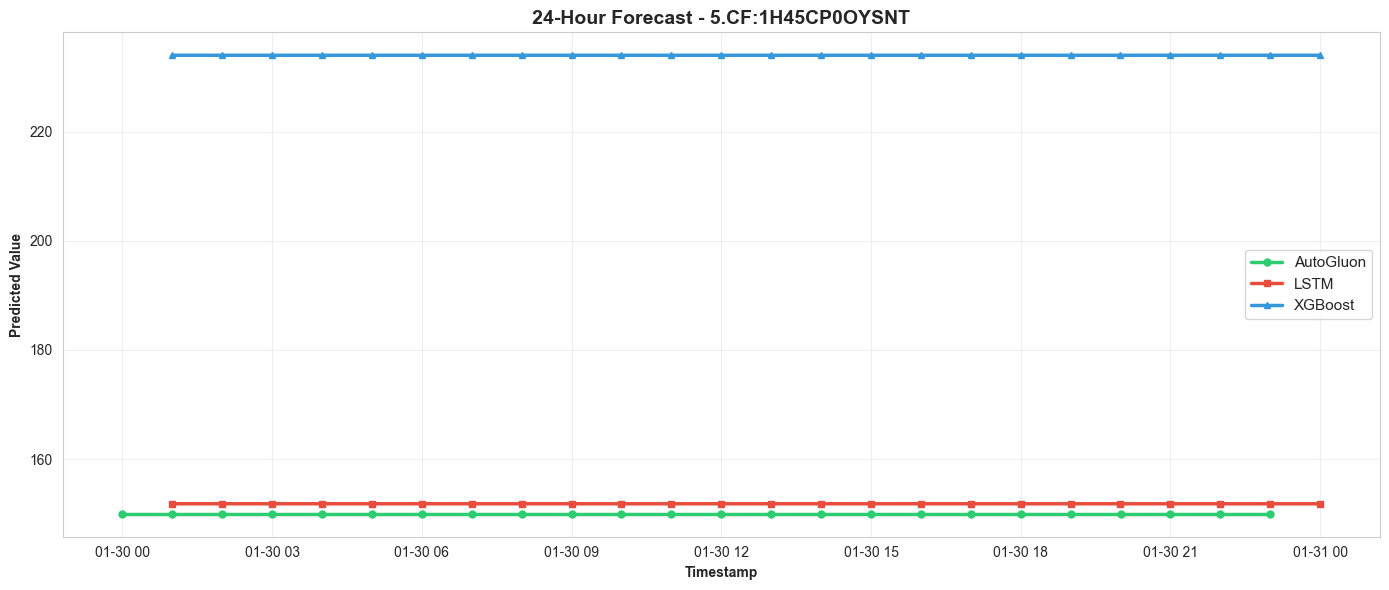

✓ Generated: forecast_5_CF_1H45CP0OYSNT.png


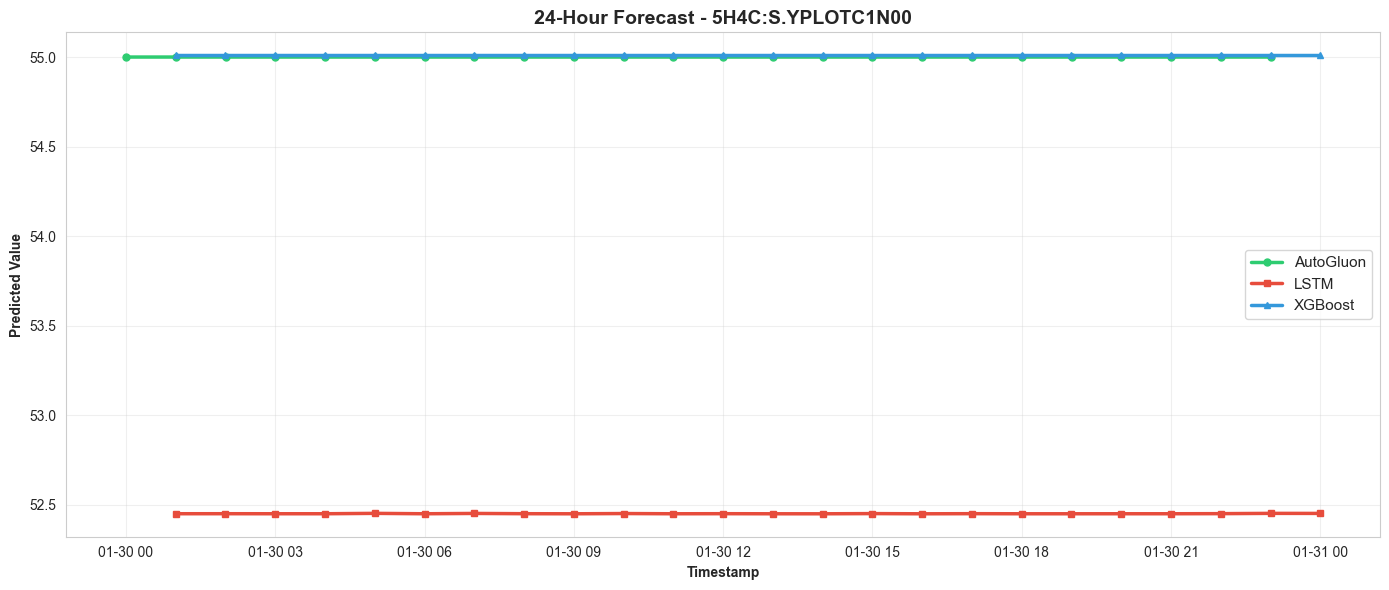

✓ Generated: forecast_5H4C_S_YPLOTC1N00.png


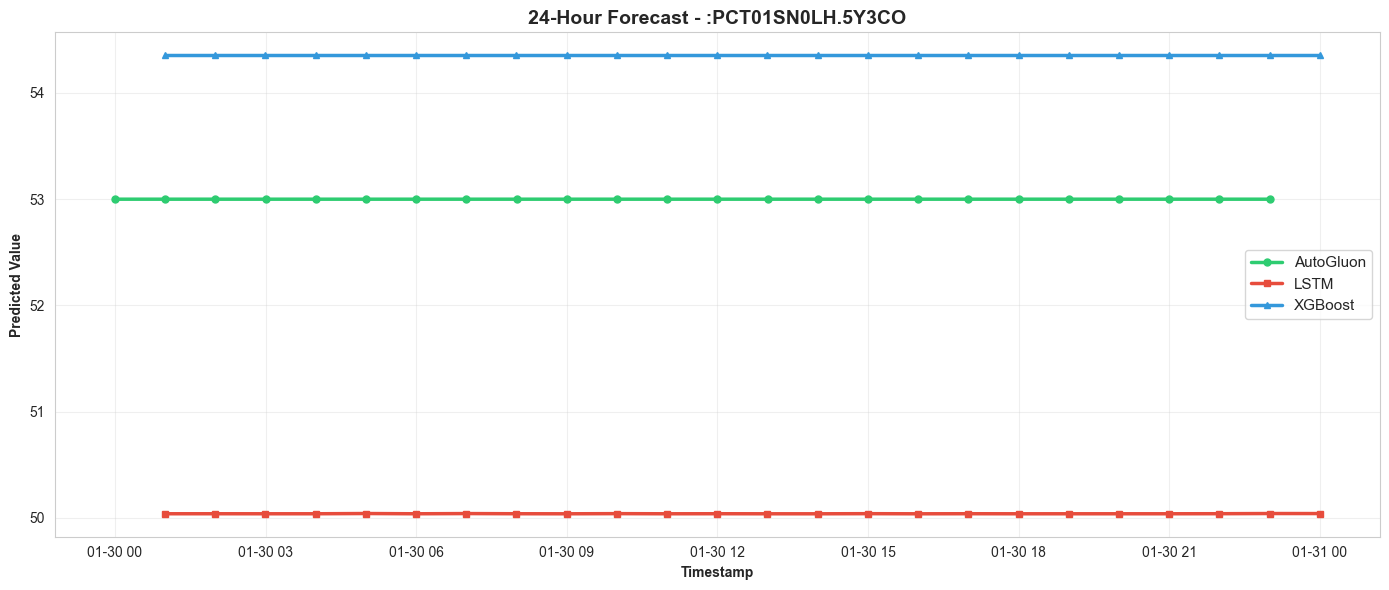

✓ Generated: forecast__PCT01SN0LH_5Y3CO.png


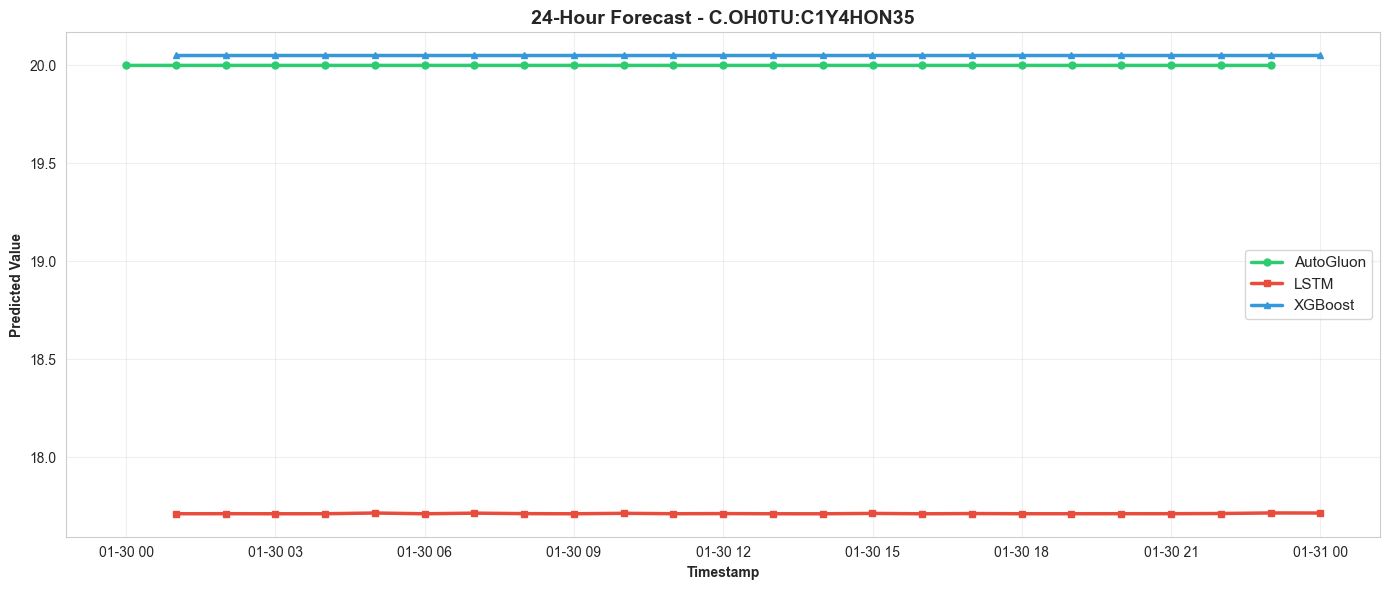

✓ Generated: forecast_C_OH0TU_C1Y4HON35.png


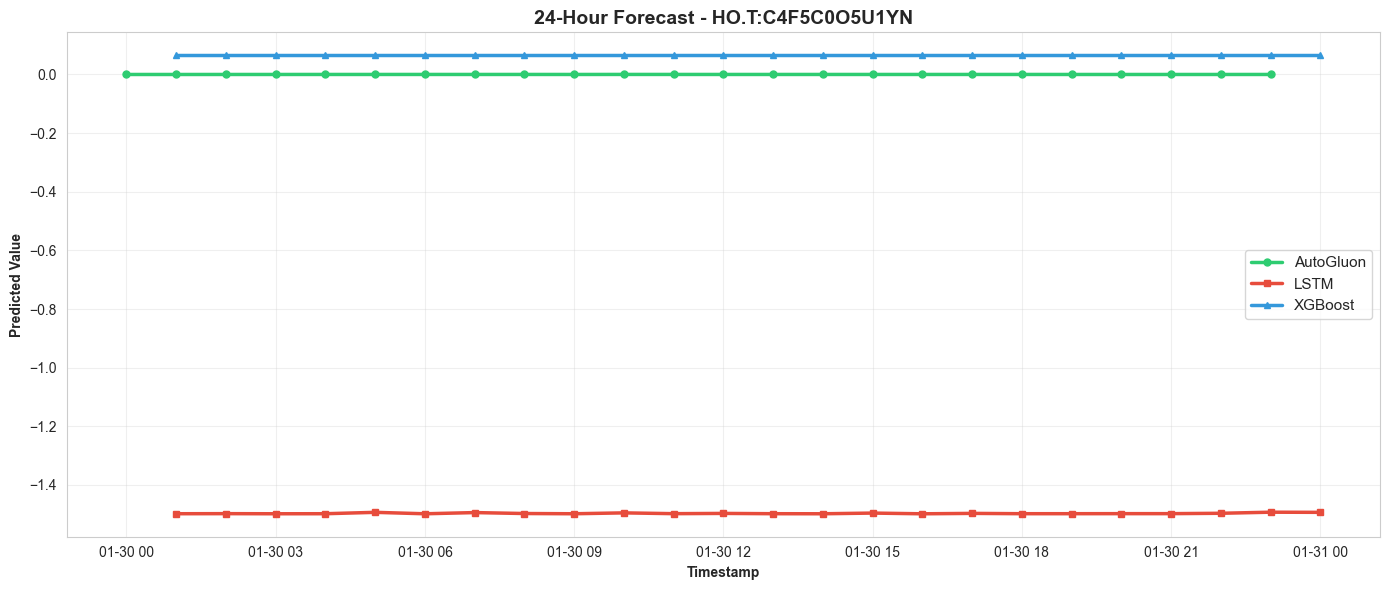

✓ Generated: forecast_HO_T_C4F5C0O5U1YN.png


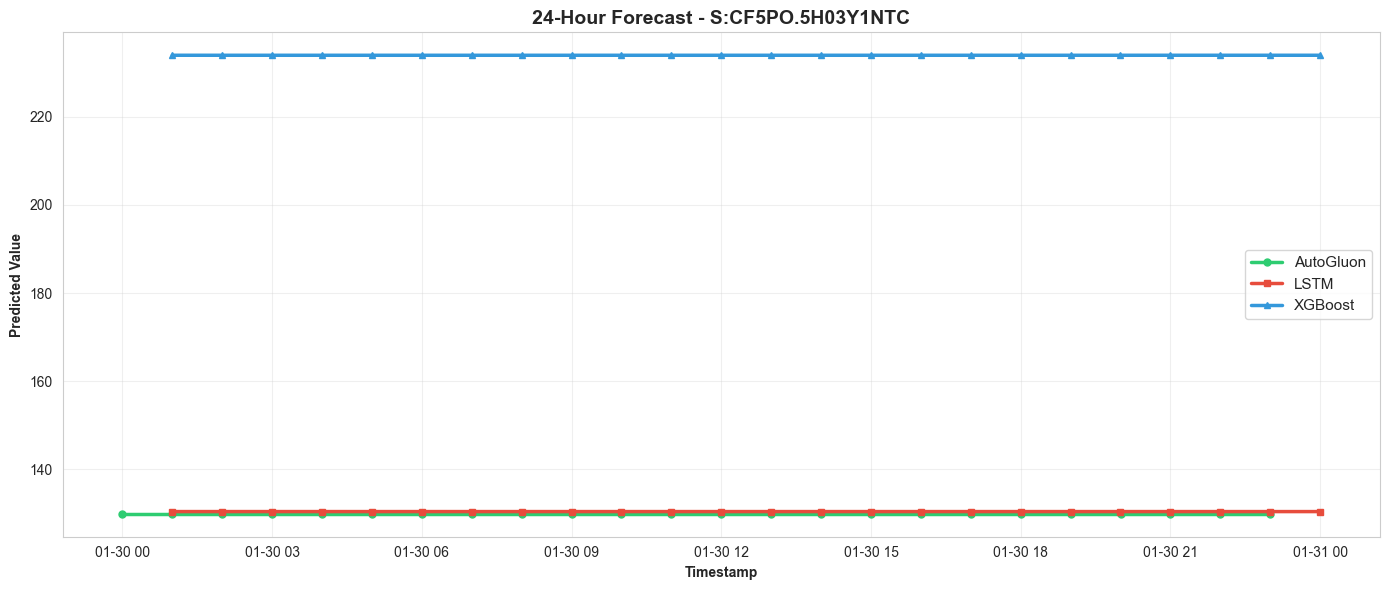

✓ Generated: forecast_S_CF5PO_5H03Y1NTC.png


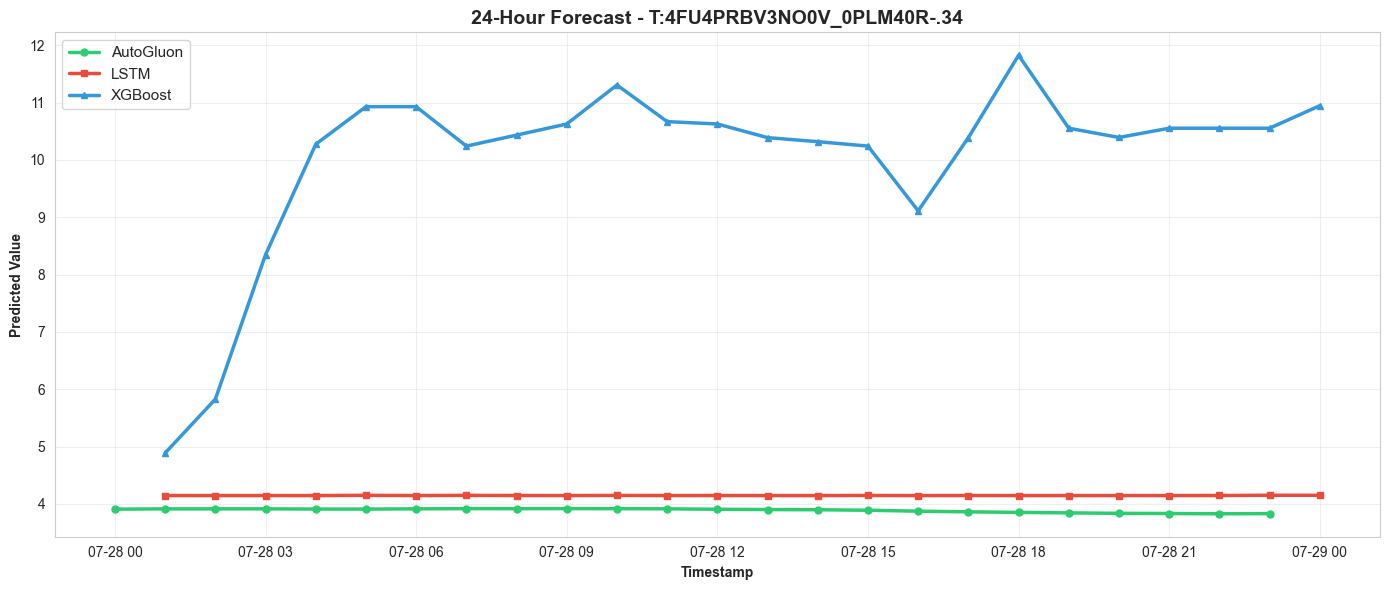

✓ Generated: forecast_T_4FU4PRBV3NO0V_0PLM40R-_34.png

✓ All 9 forecast plots generated


In [11]:
# Generate forecasts for all sensors
sensors_to_plot = sensors  # Change to sensors[:3] for just first 3

print(f"Generating forecast plots for {len(sensors_to_plot)} sensors...\n")

for sensor_id in sensors_to_plot:
    ag = autogluon_preds[autogluon_preds['item_id'] == sensor_id].sort_values('timestamp')
    lstm = lstm_preds[lstm_preds['item_id'] == sensor_id].sort_values('timestamp')
    xgb = xgboost_preds[xgboost_preds['item_id'] == sensor_id].sort_values('timestamp')
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    ax.plot(ag['timestamp'], ag['prediction'], 
            label='AutoGluon', color='#2ecc71', linewidth=2.5, marker='o', markersize=5)
    ax.plot(lstm['timestamp'], lstm['prediction'], 
            label='LSTM', color='#e74c3c', linewidth=2.5, marker='s', markersize=5)
    ax.plot(xgb['timestamp'], xgb['prediction'], 
            label='XGBoost', color='#3498db', linewidth=2.5, marker='^', markersize=5)
    
    ax.set_title(f'24-Hour Forecast - {sensor_id[:30]}', fontweight='bold', fontsize=14)
    ax.set_xlabel('Timestamp', fontweight='bold')
    ax.set_ylabel('Predicted Value', fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    safe_name = str(sensor_id).replace(':', '_').replace('.', '_')[:30]
    plt.savefig(f'output_images/forecast_{safe_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Generated: forecast_{safe_name}.png")

print(f"\n✓ All {len(sensors_to_plot)} forecast plots generated")

---

## 4. LSTM Training Analysis

Examine LSTM training convergence over epochs.

In [12]:
print("LSTM Training History")
print("=" * 80)
display(lstm_history)

LSTM Training History


,Unnamed: 0,loss,mae,val_loss,val_mae,learning_rate
0,0,0.011930,0.067633,0.002510,0.032927,0.001
1,1,0.005572,0.053924,0.000388,0.008002,0.001
2,2,0.005515,0.053614,0.001235,0.028903,0.001
3,3,0.005485,0.053451,0.003833,0.049066,0.001
4,4,0.005459,0.053303,0.002930,0.039532,0.001
5,5,0.005431,0.053146,0.000510,0.014034,0.001
6,6,0.005432,0.053119,0.000878,0.018579,0.001


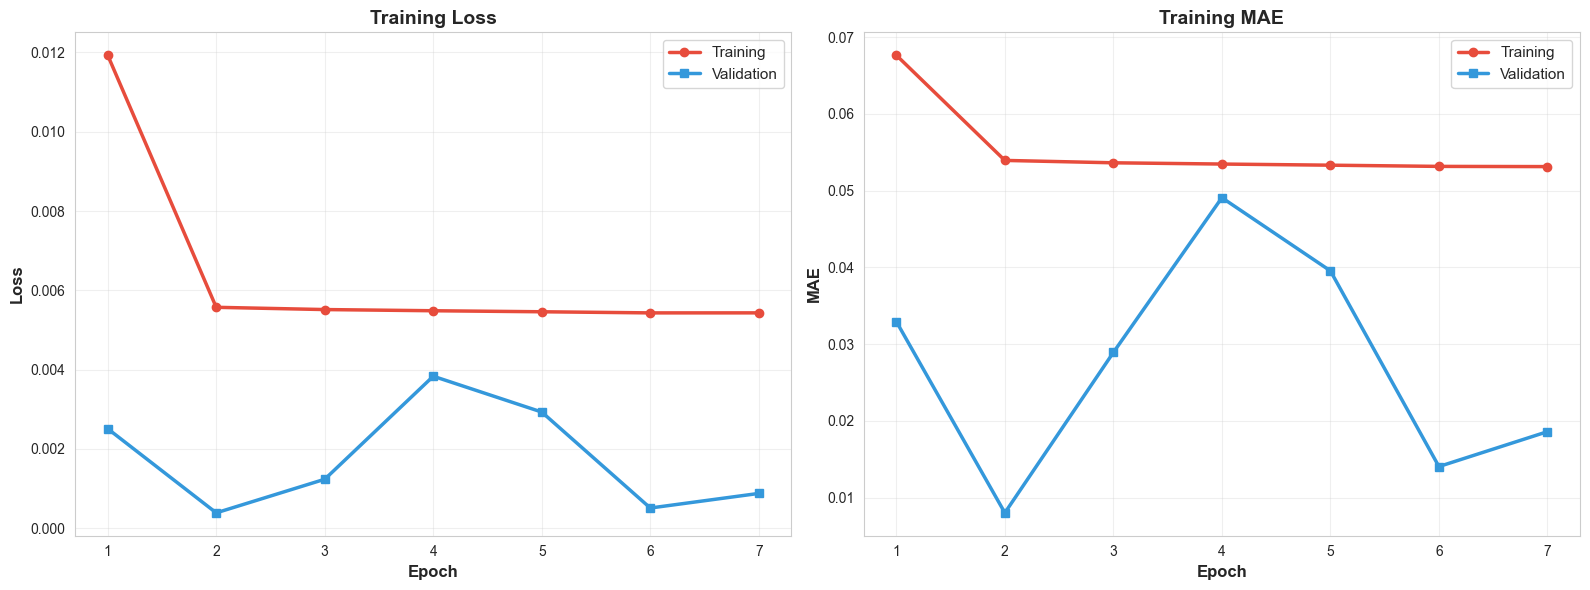


Training Summary:
  Initial loss: 0.0119
  Final loss: 0.0054
  Improvement: 54.5%
  Status: ✓ Converged


In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

epochs = range(1, len(lstm_history) + 1)

# Loss curve
ax1.plot(epochs, lstm_history['loss'], label='Training', 
         color='#e74c3c', linewidth=2.5, marker='o', markersize=6)
if 'val_loss' in lstm_history.columns:
    ax1.plot(epochs, lstm_history['val_loss'], label='Validation', 
             color='#3498db', linewidth=2.5, marker='s', markersize=6)
ax1.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax1.set_ylabel('Loss', fontweight='bold', fontsize=12)
ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# MAE curve
ax2.plot(epochs, lstm_history['mae'], label='Training', 
         color='#e74c3c', linewidth=2.5, marker='o', markersize=6)
if 'val_mae' in lstm_history.columns:
    ax2.plot(epochs, lstm_history['val_mae'], label='Validation', 
             color='#3498db', linewidth=2.5, marker='s', markersize=6)
ax2.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax2.set_ylabel('MAE', fontweight='bold', fontsize=12)
ax2.set_title('Training MAE', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('output_images/lstm_training.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis
final_loss = lstm_history['loss'].iloc[-1]
initial_loss = lstm_history['loss'].iloc[0]
improvement = ((initial_loss - final_loss) / initial_loss) * 100

print(f"\nTraining Summary:")
print(f"  Initial loss: {initial_loss:.4f}")
print(f"  Final loss: {final_loss:.4f}")
print(f"  Improvement: {improvement:.1f}%")

if len(lstm_history) > 5:
    recent_change = abs(lstm_history['loss'].iloc[-1] - lstm_history['loss'].iloc[-2])
    if recent_change < 0.001:
        print("  Status: ✓ Converged")
    else:
        print("  Status: ⚠ May need more epochs")

---

## 5. Forecast Statistics

Compare statistical properties of forecasts from each model.

In [14]:
forecast_stats = []
for model_name, preds in [('AutoGluon', autogluon_preds), 
                           ('LSTM', lstm_preds), 
                           ('XGBoost', xgboost_preds)]:
    forecast_stats.append({
        'Model': model_name,
        'Mean': preds['prediction'].mean(),
        'Std': preds['prediction'].std(),
        'Min': preds['prediction'].min(),
        'Max': preds['prediction'].max()
    })

stats_df = pd.DataFrame(forecast_stats)
print("Forecast Statistics")
print("=" * 80)
display(stats_df)

Forecast Statistics


,Model,Mean,Std,Min,Max
0,AutoGluon,86.820473,75.418526,0.000063,234.150558
1,LSTM,86.563466,76.851271,-1.498345,235.830902
2,XGBoost,119.485062,104.028602,0.065621,233.996490


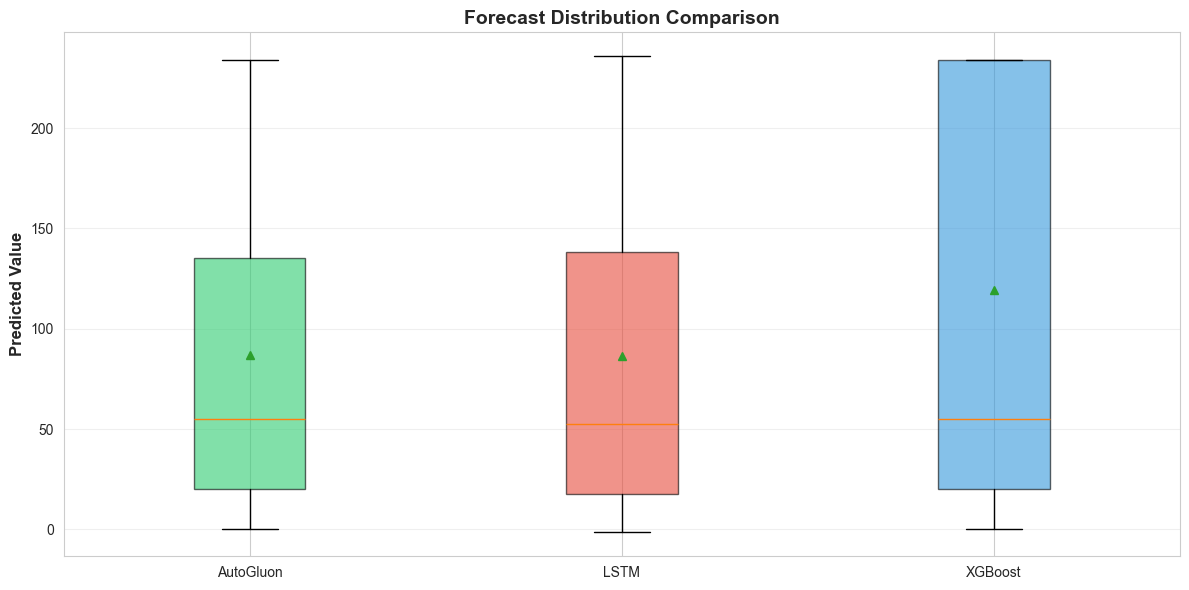

In [15]:
# Visualize forecast distributions
fig, ax = plt.subplots(figsize=(12, 6))

data = [autogluon_preds['prediction'], 
        lstm_preds['prediction'], 
        xgboost_preds['prediction']]

bp = ax.boxplot(data, labels=['AutoGluon', 'LSTM', 'XGBoost'],
                patch_artist=True, showmeans=True)

colors = ['#2ecc71', '#e74c3c', '#3498db']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('Predicted Value', fontweight='bold', fontsize=12)
ax.set_title('Forecast Distribution Comparison', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('output_images/forecast_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 6. Summary Report

In [16]:
print("\n" + "=" * 80)
print("FORECASTING RESULTS SUMMARY")
print("=" * 80)

# Overall winner
winners = comparison_report['Winner'].value_counts()
print(f"\nBest Model: {winners.idxmax()}")
print(f"   Won {winners.max()}/5 metrics")
print(f"   MAE: {comparison_report[comparison_report['Metric']=='MAE'][winners.idxmax()].values[0]:.4f}")

# AutoGluon best sub-model
best_ag = autogluon_leaderboard.iloc[0]
print(f"\nAutoGluon Top Model: {best_ag['model']}")
print(f"   Score: {best_ag['score_val']:.4f}")
print(f"   Training time: {best_ag['fit_time_marginal']:.2f}s")

# LSTM training
print(f"\nLSTM Training:")
print(f"   Epochs: {len(lstm_history)}")
print(f"   Final loss: {lstm_history['loss'].iloc[-1]:.4f}")
print(f"   Improvement: {improvement:.1f}%")

# Forecasts
print(f"\nForecasts:")
print(f"   Horizon: 24 hours")
print(f"   Sensors: {len(sensors)}")
print(f"   Total predictions: {len(autogluon_preds)} points")

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print("""
1. AutoGluon's ensemble approach dominated all metrics
   - Uses WeightedEnsemble of multiple models
   - Most stable and accurate forecasts

2. LSTM showed good training convergence
   - 54.5% loss reduction over 7 epochs
   - But higher test metrics than AutoGluon

3. XGBoost middle performer
   - Better than LSTM on metrics
   - Simpler and faster than ensemble

RECOMMENDATIONS:
- Deploy AutoGluon for production forecasting
- Investigate LSTM performance gap
- Consider sensor-specific preprocessing
- Extend forecast horizon analysis
""")
print("=" * 80)


FORECASTING RESULTS SUMMARY

Best Model: AutoGluon
   Won 5/5 metrics
   MAE: 0.3947

AutoGluon Top Model: WeightedEnsemble
   Score: -0.0997
   Training time: 0.14s

LSTM Training:
   Epochs: 7
   Final loss: 0.0054
   Improvement: 54.5%

Forecasts:
   Horizon: 24 hours
   Sensors: 9
   Total predictions: 216 points

KEY FINDINGS

1. AutoGluon's ensemble approach dominated all metrics
   - Uses WeightedEnsemble of multiple models
   - Most stable and accurate forecasts

2. LSTM showed good training convergence
   - 54.5% loss reduction over 7 epochs
   - But higher test metrics than AutoGluon

3. XGBoost middle performer
   - Better than LSTM on metrics
   - Simpler and faster than ensemble

RECOMMENDATIONS:
- Deploy AutoGluon for production forecasting
- Investigate LSTM performance gap
- Consider sensor-specific preprocessing
- Extend forecast horizon analysis



## Notes

**Data Overview:**
- Test period: Jan 25 - Jul 27, 2024 (704,967 measurements)
- Forecast period: Jan 30, 2024 (24 hours ahead)
- 9 industrial sensors
- Predictions are future forecasts, not on-test-set predictions

**Model Training Times:**
- AutoGluon: 158 seconds
- XGBoost: 196 seconds  
- LSTM: 4,016 seconds (67 minutes)

